In [124]:
import os
from os import path
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ply import read_ply
from tqdm.auto import tqdm

In [125]:
SRC_PATHS = [

    #'rgb_dataset/test/',
    #'rgb_dataset/valid/',
    #'rgb_dataset/train/',
]
TGT_PATHS = [
    #'test/',
    #'valid/',
    #'train/',
]
DATA_PATH = "E:\\GENA_RT\\DATA\\agro_hack"

In [126]:
def retrieve_location(image_name):
    chunk = image_name[:image_name.index('-')]
    package = image_name[image_name.index('-')+1: image_name.index('_png')]

    location = path.join(DATA_PATH, chunk, chunk, package)
    return location

In [138]:
def depth_map_from_ply(ply_path):
    #plydata = PlyData.read(ply_path)
    #mesh = meshio.read(
    points = read_ply(ply_path)['points'].to_numpy()

    cx = 240
    cy = len(points) // cx

    depth_map = np.zeros((cx, cy), dtype=float)
    for x in range(cx):
        for y in range(cy):
            depth_map[x][y] = np.linalg.norm(np.array(list(points[x * cy + y])))
            if depth_map[x][y] < 0.01:
                depth_map[x][y] = 15

    depth_map -= np.min(depth_map)
    depth_map = depth_map / np.max(depth_map)

    return depth_map

In [139]:
def swap_channel(rgb, depth, ch):
    rgb_np = np.array(rgb)
    depth_np = np.array(depth)
    rgb_np = np.transpose(rgb_np, (2, 0, 1))
    rgb_np[ch] = depth_np
    rgb_np = np.transpose(rgb_np, (1, 2, 0))
    return Image.fromarray(rgb_np)


In [140]:
images = os.listdir(path.join(SRC_PATHS[0], 'images'))

In [142]:
loc = retrieve_location(images[0])
depth_map = Ыdepth_map_from_ply(path.join('E:\\GENA_RT\\DATA\\agro_hack\\final_test\\20210901_152837_step_20\\package_0', 'point_cloud.ply'))

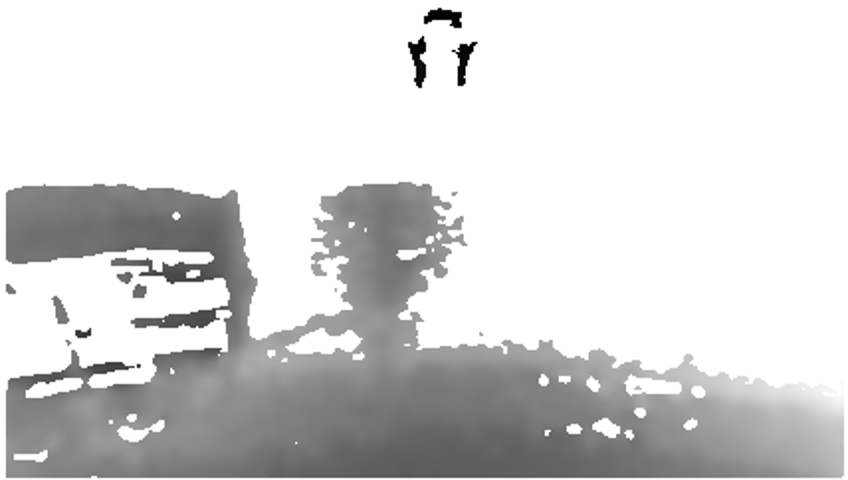

In [143]:
depth = Image.fromarray(np.uint8(depth_map * 255) , 'L')
depth = depth.resize((848, 480))
depth

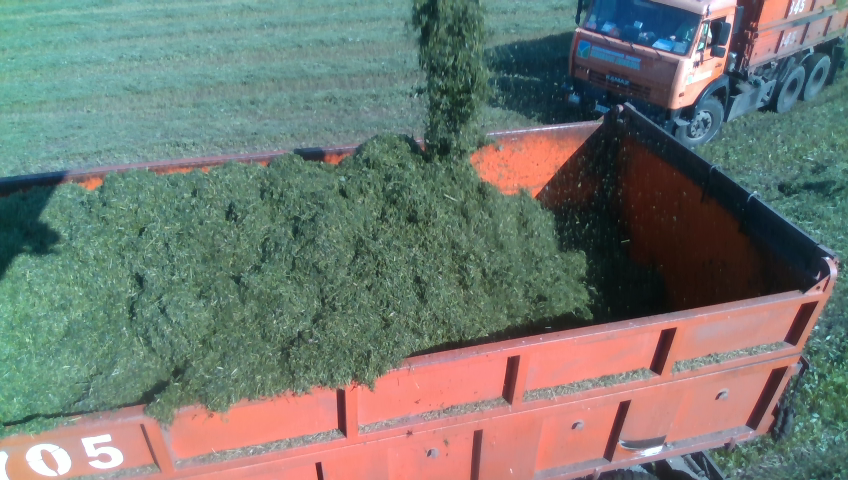

In [132]:
rgb = Image.open(path.join(loc, 'color_frame.png'))
rgb

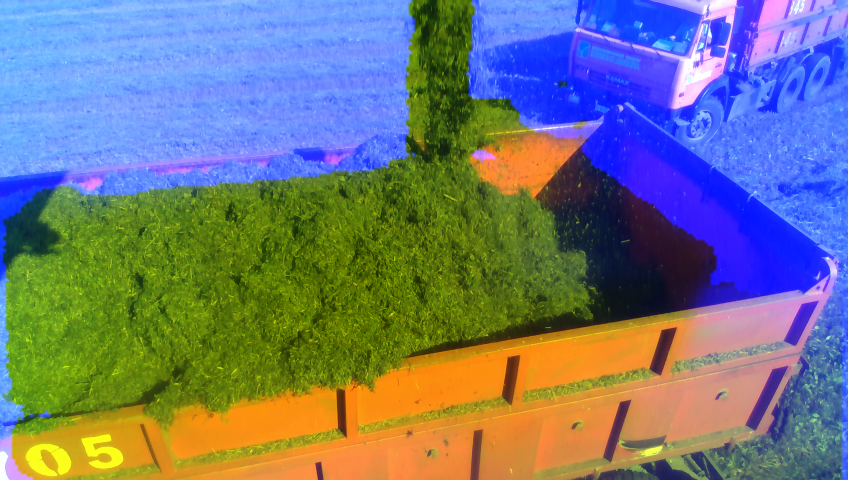

In [133]:
swap_channel(rgb, depth, 2)

In [134]:
for src_path, tgt_path in zip(SRC_PATHS, TGT_PATHS):
    if os.path.exists(tgt_path) and os.path.isdir(tgt_path):
        shutil.rmtree(tgt_path)
    tgt_images_path = path.join(tgt_path, 'images')
    tgt_labels_path = path.join(tgt_path, 'labels')
    os.makedirs(tgt_images_path)

    shutil.copytree(path.join(src_path, 'labels'), path.join(tgt_path, 'labels'))

    images = os.listdir(path.join(src_path, 'images'))

    for image in tqdm(images):
        loc = retrieve_location(image)

        depth_map = depth_map_from_ply(path.join(loc, 'point_cloud.ply'))
        depth = Image.fromarray(np.uint8(depth_map * 255) , 'L')
        depth = depth.resize((848, 480))

        rgb = Image.open(path.join(loc, 'color_frame.png'))

        swapped = swap_channel(rgb, depth, 2)
        swapped.save(path.join(tgt_images_path, image))

  0%|          | 0/500 [00:00<?, ?it/s]